In [7]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp

sys.path.append("../scripts")
sys.path.append("../src/iw_model")
sys.path.append("../src/iw_inverse")
sys.path.append("../src/misc")
from iw_invert import InternalWaveInversion
from extract import *

In [3]:
"""
Read data and compute means, extrapolate isopyncnal displacments
"""
path = os.path.join("..","matlab",filename)

table = read_table(path)
N2 = extract_node(table,'N2')
T  = extract_node(table,'T')
S  = extract_node(table,'S')
Z  = extract_node(table,'z').flatten()

#Compute the mean stratification
DSL = slice(20,70) # depth slice
N2_mean = np.mean(N2,axis=(0,2,3))
T_mean  = np.mean(T,axis=(0,2,3))
S_mean  = np.mean(S,axis=(0,2,3))
R_mean  = sw.eos80.dens(S_mean[DSL],T_mean[DSL],Z[DSL])

#Define a slice
sl = (slice(0,-1),DSL,slice(0,-1),slice(0,-1))

#Subsample matrices
TP = T[sl]
SP = S[sl]
NP = N2[sl]

#Grab Axes Data
TIME   = extract_node(table,'time').flatten()[sl[0]]
LAT    = extract_node(table,'lat')[:,0][sl[2]]
LON    = extract_node(table,'lon')[0,:][sl[3]]
DEPTH  = extract_node(table,'z').flatten()[sl[1]]

#Convert matlab timestamps
t0 = matlab2datetime(TIME[0]).timestamp()
TIME = [round(matlab2datetime(T).timestamp()-t0) for T in TIME]
X = 1e3*np.arange(0,22,2)
Y = 1e3*np.arange(0,22,2)

#Form a coordinate matrix
AX = np.array(list(itertools.product(*[TIME,DEPTH,X,Y])),dtype=[('t',float),('z',float),('x',float),('y',float)])
AX = AX.reshape(TP.shape)

#Compute Density from state variables
RP = sw.eos80.dens(SP,TP,AX['z'])

#Create a function that is depth as a function of the mean density
zofr = interp.InterpolatedUnivariateSpline(R_mean,Z[DSL])
DZ   = zofr(RP) - AX['z']



Text(0.5, 1.0, 'Isopycnal Displacements @[251.77000427]')

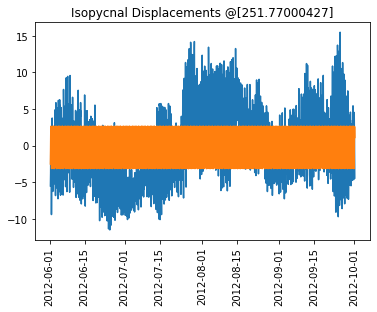

In [6]:
"""
Compute Inversion Single Point in Time
"""
#Pick a single point in time construct dataframe
spit = pd.DataFrame({"dz"    : DZ[:,10,0,0],
                     "time"  : AX[:,10,0,0]["t"],
                     "z"     : AX[:,10,0,0]["z"],
                     "x"     : 0,
                     "y"     : 0})
spit['date'] = pd.to_datetime(spit['time'] + t0, unit='s')

#Set up parameter space
FREQS= [0,.0805/3600,2*.0805/3600]
MODES= [1]
ANGLES= [0,1]

#Run inversion
iwi = InternalWaveInversion(spit,FREQS,MODES,ANGLES,Z[DSL],N2_mean[DSL],tc='dz')
iwi.pinvert()

#Compute an estimate
dz_hat = iwi.H @ np.concatenate([iwi.ps['a'],iwi.ps['b']]).T


plt.plot(spit['date'],spit["dz"])
plt.plot(spit['date'],dz_hat)
plt.xticks(rotation='vertical')
plt.title("Isopycnal Displacements @" + str( np.unique(spit['z']) ) )